In [2]:
from bs4 import BeautifulSoup # modulo de BeautifulSoup
import requests
import ssl
import json

# Spyding

The idea is to gather data from the web. We need to first select a web (and its [URL](https://psdeals.net/tr-store)) to extract the data. We need info regarding the price of a game in the Turkey store. At the very beginning, we'll use [this website](https://psdeals.net/tr-store) to construct the data.

In this first step, we will analyze how the website is constructed and how we can obtain mainly the price and the name of the game that we search for.


## Step 1: The URL

Doing the search. In this case let's create a tool to search an specific term in the web. Let's suppose that we are interested in searching the name of the game God of War. The main page looks like this:

<img src="../pics/main page.png" alt="Main Page" width="500"/>

But, after we do a search this is the result. Now we need to look at the structure of the URL created to do the search.

<img src="../pics/search-page.png" alt="Search Page" width="500"/>

This means that the url has an standard search ith aprameters added. The standard urls is something like `https://psdeals.net/tr-store/search?search_query=` and the searched item is added to the url separed by a "+" symbol. 

So, with that in mind...


In [3]:
# let's create a function to generate URLs of the games that we want to search
def search_games():
    """
    Generates search URLs for the given items.

    Args: 
        None. The games' names are provided by the user through the console.

    Returns:
        List[str]: A list of URLs to search for the specified games.
    """
    items = []
    game = input("Insert a game (or press enter to finish): ")
    while game != "":
        items.append(game)
        game = input("Insert a game (or press enter to finish): ")

    # Generating URLs to search :D
    base_url = "https://psdeals.net/tr-store/search?search_query="
    urls = [base_url + i.replace(" ", "+") for i in items]

    print("You asked for: {}".format(", ".join(items)))
    return urls

urls = search_games()
print(urls)



You asked for: god of war, sekiro, spiderman
['https://psdeals.net/tr-store/search?search_query=god+of+war', 'https://psdeals.net/tr-store/search?search_query=sekiro', 'https://psdeals.net/tr-store/search?search_query=spiderman']


# Step 2: The Soup

Now that we have the URLs, we can extract the data from the pages.

For this step, we will use the `requests` library to fetch the pages and the `BeautifulSoup` library to parse the HTML.

First, we need to install the required libraries. If you dont have them well... Go on! Do it, and then i'll illustrate you my dear commrade. 

With that being said, let us cook a beautiful Soup!

In [50]:
# With only 1 URL: Just to get 
url = urls[0]
headers={
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive'
}
r = requests.get(url, headers=headers)
print("Status code:", r.status_code)
print("Encoding:", r.encoding)
soup = BeautifulSoup(r.text, "lxml")

Status code: 200
Encoding: UTF-8


well, we have now a page woth all the data regarding the search. If we look at the "soup"; we have all the ingredients but is kinda messy to understand due the "html" format. indeed, if we look at a general idea of the html code of the full page we would find hard to unedrstand all formats and where to search.

A pretty useful tactic is to identify a portion of what we are looking for wihtihn the webpage and then try to figure out (more or less) where is the info that we are looking for (price and game name).

<img src="../pics/web inspection.png" alt="Search Page" width="500"/>

If we look at the inspect parameter in the web browser, we discover that game price is somehow within a tag called "dev" with differentes classes. Now this is a child tag from a parent tag called "div" with class "ga,e-collection-item-details-title"

So a very good first step is to look out in this section. Let's see what we can find there....

[<div class="game-collection-item col-md-2 col-sm-4 col-xs-6" itemscope="" itemtype="http://schema.org/Product">
 <a class="game-collection-item-link" href="/tr-store/game/68749/god-of-war-ghost-of-sparta-psp">
 <div class="game-collection-item-container" style="background-color: #7E5E49">
 <div class="game-collection-item-top">
 <img alt="TR" class="game-collection-item-top-flag" data-pagespeed-url-hash="2165738322" onload="pagespeed.CriticalImages.checkImageForCriticality(this);" src=""/>
 <span class="game-collection-item-top-platform">PS Vita / PSP</span>
 </div>
 <div class="game-collection-item-image-placeholder">
 <picture>
 <source data-srcset="https://store.playstation.com/store/api/chihiro/00_09_000/container/TR/tr/99/EP9000-NPEG00044_00-GPCGODOFWA000001/0/image?_version=00_09_000&amp;platform=chihiro&amp;bg_color=000000&amp;opacity=100&amp;w=153&amp;h=153 1x, https://store.playstation.com/store/api/chihiro/00_09_000/container/TR/tr/99/EP9000-NPEG00044_00-GPCGODOFWA000001/0/i
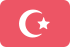
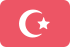
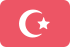
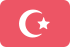
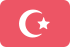
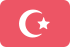
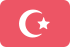
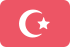
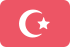
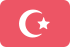
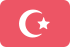
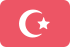
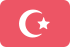
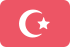
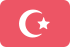
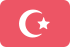
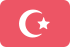
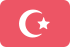

In [113]:
soup.find_all("div", class_= "game-collection-item")

I gotta be honest. I cant see a shit here. So lets write this as a txt file and then, we wil format it as a propper html. 

In [131]:
tags_txt = soup.find_all("div", class_="game-collection-item")
tags_html_combined = "\n".join(str(tag) for tag in tags_txt)
with open("games_tags.html", "w", encoding="utf-8") as file:
    file.write(tags_html_combined)


And guess what? We discovered something interesting...

<img src="../pics/findinf game.png" alt="Search Page" width="700"/>

We discovered now that the order is more or less like this:

div class: 

In [138]:
tags = soup.find_all("div", class_= "game-collection-item col-md-2 col-sm-4 col-xs-6" )
conainters = []
for i in tags:
    conainters.append(i.find("div", class_ ="game-collection-item col-md-2 col-sm-4 col-xs-6" ))

In [142]:
# SOLUCION DE CHAT GPT
# Buscar productos y precios en la estructura de etiquetas identificada
product_details = []

# Buscar productos en la clase 'game-collection-item'
products = soup.find_all('div', class_='game-collection-item')

for product in products:
    # Buscar la etiqueta que contiene el nombre del producto
    name_tag = product.find('span', class_='game-collection-item-details-title')
    
    # Buscar la etiqueta que contiene el precio del producto
    price_tag = product.find('span', class_='game-collection-item-price')
    
    # Buscar la etiqueta que contiene la plataforma del producto
    platform_tag = product.find('span', class_='game-collection-item-top-platform')
    
    # Si encontramos el nombre, el precio y la plataforma, los extraemos y almacenamos
    if name_tag and price_tag and platform_tag:
        name = name_tag.get_text(strip=True)  # Extraer el texto del nombre
        price = price_tag.get_text(strip=True)  # Extraer el texto del precio
        platform = platform_tag.get_text(strip=True)  # Extraer el texto de la plataforma
        product_details.append((name, price, platform))  # Agregar el nombre, el precio y la plataforma a la lista

product_details


[('God of War®: Ghost of Sparta [PSP]', '36.00 TL', 'PS Vita / PSP'),
 ('God of War®: Ghost of Sparta', '69.00 TL', 'PS3'),
 ('God of War®: Chains of Olympus', '69.00 TL', 'PS3'),
 ('God of War Ragnarök Digital Deluxe Sürümü', '2,249.00 TL', 'PS5 / PS4'),
 ('God of War Ragnarök', '2,799.00 TL', 'PS5 / PS4'),
 ('God of War Ragnarök', '2,499.00 TL', 'PS4'),
 ('God of War™', '499.00 TL', 'PS4'),
 ('God of War Comic Book 1', 'FREE', 'PS4'),
 ('God of War™ Dijital Deluxe Sürüm', '749.00 TL', 'PS4'),
 ('God of War® II HD', '69.00 TL', 'PS3'),
 ('God of War® HD', '69.00 TL', 'PS3'),
 ('God of War® Collection', '84.00 TL', 'PS3'),
 ('God of War® Collection Volume II', '84.00 TL', 'PS3'),
 ('God of War: Ascension™', '64.00 TL', 'PS3'),
 ('God of War® Collection', '114.00 TL', 'PS Vita'),
 ('God of War: Ascension™ Ultimate Edition', '84.00 TL', 'PS3'),
 ('God of War® III Remastered', '699.00 TL', 'PS4'),
 ('God\xa0of\xa0War®:\xa0Chains\xa0of\xa0Olympus [PSP]',
  '36.00 TL',
  'PS Vita / PSP')]

# Con url 2:

Miremos si es replicable

In [143]:
url = urls[1]
headers={
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive'
}
r = requests.get(url, headers=headers)
print("Status code:", r.status_code)
print("Encoding:", r.encoding)
soup = BeautifulSoup(r.text, "lxml")

# SOLUCION DE CHAT GPT
# Buscar productos y precios en la estructura de etiquetas identificada
product_details = []

# Buscar productos en la clase 'game-collection-item'
products = soup.find_all('div', class_='game-collection-item')

for product in products:
    # Buscar la etiqueta que contiene el nombre del producto
    name_tag = product.find('span', class_='game-collection-item-details-title')
    
    # Buscar la etiqueta que contiene el precio del producto
    price_tag = product.find('span', class_='game-collection-item-price')
    
    # Buscar la etiqueta que contiene la plataforma del producto
    platform_tag = product.find('span', class_='game-collection-item-top-platform')
    
    # Si encontramos el nombre, el precio y la plataforma, los extraemos y almacenamos
    if name_tag and price_tag and platform_tag:
        name = name_tag.get_text(strip=True)  # Extraer el texto del nombre
        price = price_tag.get_text(strip=True)  # Extraer el texto del precio
        platform = platform_tag.get_text(strip=True)  # Extraer el texto de la plataforma
        product_details.append((name, price, platform))  # Agregar el nombre, el precio y la plataforma a la lista

product_details

Status code: 200
Encoding: UTF-8


[('Sekiro™: Shadows Die Twice - Game of the Year Sürümü', '469.00 TL', 'PS4')]

# URL 3


In [144]:
url = urls[2]
headers={
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36',
    'Accept-Language': 'en-US,en;q=0.9',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive'
}
r = requests.get(url, headers=headers)
print("Status code:", r.status_code)
print("Encoding:", r.encoding)
soup = BeautifulSoup(r.text, "lxml")

# SOLUCION DE CHAT GPT
# Buscar productos y precios en la estructura de etiquetas identificada
product_details = []

# Buscar productos en la clase 'game-collection-item'
products = soup.find_all('div', class_='game-collection-item')

for product in products:
    # Buscar la etiqueta que contiene el nombre del producto
    name_tag = product.find('span', class_='game-collection-item-details-title')
    
    # Buscar la etiqueta que contiene el precio del producto
    price_tag = product.find('span', class_='game-collection-item-price')
    
    # Buscar la etiqueta que contiene la plataforma del producto
    platform_tag = product.find('span', class_='game-collection-item-top-platform')
    
    # Si encontramos el nombre, el precio y la plataforma, los extraemos y almacenamos
    if name_tag and price_tag and platform_tag:
        name = name_tag.get_text(strip=True)  # Extraer el texto del nombre
        price = price_tag.get_text(strip=True)  # Extraer el texto del precio
        platform = platform_tag.get_text(strip=True)  # Extraer el texto de la plataforma
        product_details.append((name, price, platform))  # Agregar el nombre, el precio y la plataforma a la lista

product_details

Status code: 200
Encoding: UTF-8


[('Marvel’s Spider-Man 2 Dijital Deluxe Sürümü', '1,699.00 TL', 'PS5'),
 ('Marvel’s Spider-Man 2', '1,999.00 TL', 'PS5'),
 ("Marvel's Spider-Man Remastered", '466.78 TL', 'PS5'),
 ("Marvel's Spider-Man: Miles Morales Ultimate Edition",
  '619.00 TL',
  'PS5 / PS4'),
 ("Marvel's Spider-Man: Miles Morales PS4 and PS5", '459.00 TL', 'PS5 / PS4'),
 ('Marvel’s Spider-Man: Game of the Year Edition', '309.00 TL', 'PS4'),
 ('Marvel’s Spider-Man', '249.00 TL', 'PS4')]